# Final Project
### Shintaro Osuga

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import xgboost
import numba as nb
from numba import cuda
import sklearn

## Getting Data

In [15]:
from scipy.io import loadmat
data = loadmat('data.mat')

In [16]:
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available 1


In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
X_train = np.array(data["X_train"])
y_train = np.array(data["y_train"])
X_test = np.array(data["X_test"])

## Setting up Neural Network model

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.optimizers import *

# class_weight = {0:8.,
#                1:32.,
#                2:60.}
with tf.device('/gpu:0'):
    model = keras.Sequential(
        [
            layers.Dense(10000, kernel_initializer='he_normal', activation="relu", name="layer1"),
            layers.Dense(100, kernel_initializer='he_normal', activation='relu', name="layer2"),
            layers.Dense(3, activation="softmax", name="layer6"),
        ]
    )

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


## PCA Pre-Processing

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=90)
X_train_2 = preprocessing.normalize(X_train, norm='l2')
X_trpap = pca.fit(X_train_2)
X_tran = pca.fit_transform(X_train_2)

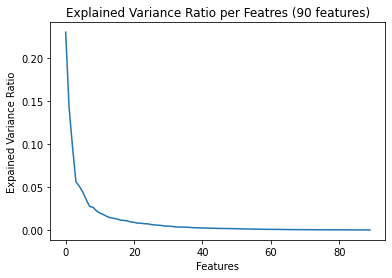

In [22]:
plt.clf()
plot = plt.plot(np.arange(0,X_trpap.explained_variance_ratio_.size), X_trpap.explained_variance_ratio_)
plt.xlabel('Features')
plt.ylabel('Expained Variance Ratio')
plt.title('Explained Variance Ratio per Featres (90 features)')
plt.show(plot)

The threshold where the explained variance ratio is essentially zero is 40, so drop the last 40 features and re-run PCA with n-components = 40

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=40)
X_train_2 = preprocessing.normalize(X_train, norm='l2')
X_trpap = pca.fit(X_train_2)
X_tran = pca.fit_transform(X_train_2)

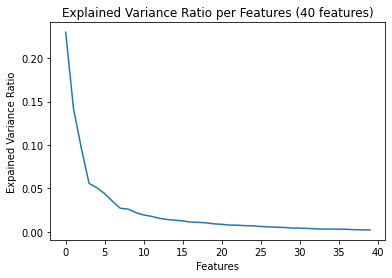

In [24]:
plt.clf()
plot = plt.plot(np.arange(0,X_trpap.explained_variance_ratio_.size), X_trpap.explained_variance_ratio_)
plt.xlabel('Features')
plt.ylabel('Expained Variance Ratio')
plt.title('Explained Variance Ratio per Features (40 features)')
plt.show(plot)

### Since after column 40 the explained variance ratio is near 0, anything after is dropped to improve computation time

## Train Test Split Data

In [25]:
gx_train, gx_test, gy_train, gy_test = train_test_split(X_tran, y_train.T, test_size=0.3, random_state=8)

## Create Weights for each Class

In [26]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes=np.unique(y_train), y=y_train.reshape(len(y_train[0])))

In [27]:
weight = {i : class_weights[i] for i in range(3)}

## Fit model

In [34]:
gx_train.shape

(324600, 40)

In [36]:
gy_train.shape

(324600, 1)

In [39]:
with tf.device('/gpu:0'):
    model.fit(gx_train, gy_train, epochs=200, batch_size=200, verbose=0, class_weight=weight)

In [ ]:
model.fit(gx_train, gy_train, epochs=200, batch_size=200, verbose=0, class_weight=weight, callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=2)])

In [54]:
yhat=model.predict(gx_test)

4348/4348 [==============================] - 9s 1ms/step


In [40]:
loss, acc = model.evaluate(gx_test, gy_test)

4348/4348 [==============================] - 9s 2ms/step - loss: 4.8261 - accuracy: 0.5877


## Hyperparameter Tuning

In [26]:
def calc_weights(y):
    class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes=np.unique(y), y=y.reshape(len(y[0])))
    weight = {i : class_weights[i] for i in range(3)}
    return weight

In [27]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

def tune_batchsize(X, y, epoch, patience, depth):
    pca = PCA(n_components=len(X[0]))
    X_2 = preprocessing.normalize(X, norm='l2')
    X_tran = pca.fit_transform(X_2)
    x_train, x_test, y_train, y_test = train_test_split(X_tran[:,0:40], y.T, test_size=0.3, random_state=8)
    weights = calc_weights(y)
    
    loss_list = []
    acc_list = []
    batchsize_list = []
    
    batchsize = 25
    for x in range(depth):
        model.fit(x_train, y_train, epochs=epoch, batch_size=batchsize, verbose=0, class_weight=weights, callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=patience)])
        loss, acc = model.evaluate(x_test, y_test)
        batchsize_list.append(batchsize)
        acc_list.append(acc)
        loss_list.append(loss)
        batchsize += 25
    
    return np.asarray(loss_list), np.asarray(acc_list), np.asarray(batchsize_list)

In [28]:
lossl, accl, bsl = tune_batchsize(X_train, y_train, 100, 2, 8)

4348/4348 [==============================] - 13s 2ms/step - loss: 6.6457 - accuracy: 0.5871


Text(0.5, 1.0, 'Batch Size vs Loss')

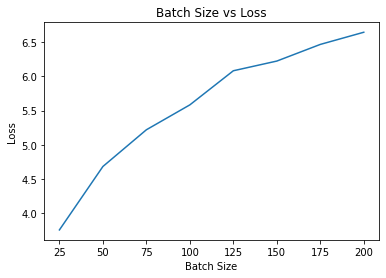

In [43]:
plt.plot(bsl,lossl)
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.title('Batch Size vs Loss')

Text(0.5, 1.0, 'Batch Size vs Accuracy')

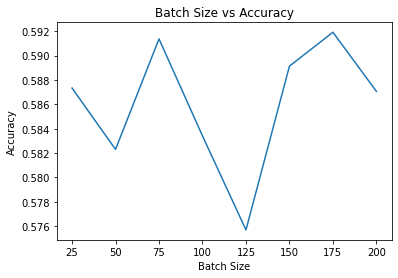

In [44]:
plt.plot(bsl,accl)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Batch Size vs Accuracy')

Text(0.5, 1.0, 'Loss vs Accuracy')

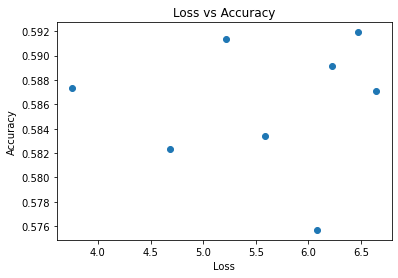

In [45]:
plt.scatter(lossl,accl)
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.title('Loss vs Accuracy')

In [32]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

def tune_epoch(X, y, batchsize, patience, depth):
    pca = PCA(n_components=len(X[0]))
    X_2 = preprocessing.normalize(X, norm='l2')
    X_tran = pca.fit_transform(X_2)
    x_train, x_test, y_train, y_test = train_test_split(X_tran[:,0:40], y.T, test_size=0.3, random_state=8)
    weights = calc_weights(y)
    
    loss_list = []
    acc_list = []
    epoch_list = []
    
    epoch = 25
    for x in range(depth):
        model.fit(x_train, y_train, epochs=epoch, batch_size=batchsize, verbose=0, class_weight=weights, callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=patience)])
        loss, acc = model.evaluate(x_test, y_test)
        epoch_list.append(epoch)
        acc_list.append(acc)
        loss_list.append(loss)
        print(epoch)
        epoch += 25
    
    return np.asarray(loss_list), np.asarray(acc_list), np.asarray(epoch_list)

In [33]:
lossle, accle, epochl = tune_epoch(X_train, y_train, 50, 2, 8)

4348/4348 [==============================] - 13s 2ms/step - loss: 5.5091 - accuracy: 0.5833
25
4348/4348 [==============================] - 13s 2ms/step - loss: 5.3366 - accuracy: 0.5860
50
4348/4348 [==============================] - 13s 2ms/step - loss: 5.4287 - accuracy: 0.5786
75
4348/4348 [==============================] - 13s 2ms/step - loss: 5.2992 - accuracy: 0.5754
100
4348/4348 [==============================] - 12s 2ms/step - loss: 5.3457 - accuracy: 0.5793
125
4348/4348 [==============================] - 13s 2ms/step - loss: 5.3174 - accuracy: 0.5844
150
4348/4348 [==============================] - 14s 2ms/step - loss: 5.2701 - accuracy: 0.5874
175
4348/4348 [==============================] - 13s 2ms/step - loss: 5.6065 - accuracy: 0.5867
200


Text(0.5, 1.0, 'Epoch Size vs Loss')

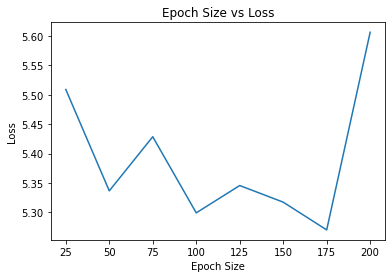

In [46]:
plt.plot(epochl, lossle)
plt.xlabel('Epoch Size')
plt.ylabel('Loss')
plt.title('Epoch Size vs Loss')

Text(0.5, 1.0, 'Epoch Size vs Accuracy')

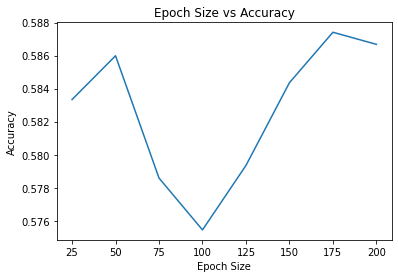

In [47]:
plt.plot(epochl, accle)
plt.xlabel('Epoch Size')
plt.ylabel('Accuracy')
plt.title('Epoch Size vs Accuracy')

Text(0.5, 1.0, 'Loss vs Accuracy')

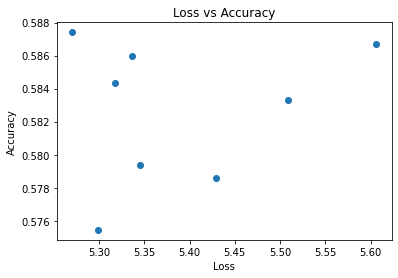

In [48]:
plt.scatter(lossle, accle)
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.title('Loss vs Accuracy')

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=90)
X_test_2 = preprocessing.normalize(X_test, norm='l2')
X_trpap = pca.fit(X_test_2)
X_test_tran = pca.fit_transform(X_test_2)

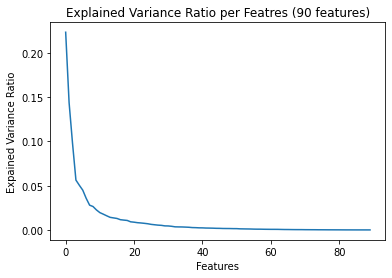

In [60]:
plt.clf()
plot = plt.plot(np.arange(0,X_trpap.explained_variance_ratio_.size), X_trpap.explained_variance_ratio_)
plt.xlabel('Features')
plt.ylabel('Expained Variance Ratio')
plt.title('Explained Variance Ratio per Featres (90 features)')
plt.show(plot)

In [41]:
test_y_pred = model.predict(X_test[:,0:40])

1614/1614 [==============================] - 2s 1ms/step


In [43]:
X_test.shape

(51630, 90)

In [42]:
test_y_pred.shape

(51630, 3)

In [44]:
test_err_pred = 1 - acc

In [78]:
test_err_pred.dtype

AttributeError: 'float' object has no attribute 'dtype'

In [75]:
np.savetxt("y_pred.gz", summ, delimiter=",", fmt="%d")
np.savetxt("err_pred.txt", [test_err_pred])

In [63]:
summ = np.sum(test_y_pred, axis =1)

In [73]:
summ = summ.reshape(len(summ),1)

In [74]:
summ

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [76]:
import gzip
f=gzip.open('y_pred.gz','rb')
file_content=f.read()
print(file_content)

b'1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r\n1\r

In [77]:
import gzip

with gzip.open('y_pred.gz','rb') as fin:        
    for line in fin:        
        print(line)

b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b